In [1]:
import pandas as pd
import tensorflow as tf
df_train=pd.read_csv("train.csv",dtype=str)
df_test=pd.read_csv("test.csv",dtype=str)

In [2]:
train_files=df_train.iloc[:,0].values
train_labels=df_train.iloc[:,1].values
print(len(train_files))

2528


# Calculate the number of target features

C:\Users\yantinglai\anaconda3\envs\tf2.0\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


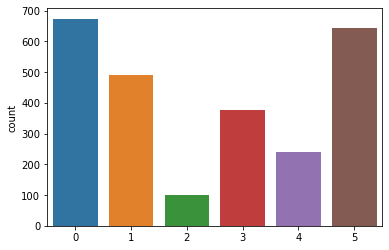

In [3]:
import seaborn as sns 
g=sns.countplot(train_labels, order=["0","1","2","3","4","5"])

# change weight

In [4]:
from sklearn.utils import class_weight
import numpy as np 
class_weight=class_weight.compute_class_weight("balanced",np.unique(train_labels),train_labels)

C:\Users\yantinglai\anaconda3\envs\tf2.0\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=['0' '1' '2' '3' '4' '5'], y=['0' '1' '1' ... '3' '0' '5'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


# train_test_split

In [5]:
from sklearn.model_selection import train_test_split
train,valid=train_test_split(df_train,test_size=0.2,random_state=66)

# generate data

In [6]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                    rotation_range=0,
                                    horizontal_flip=False,
                                    vertical_flip=False,
                                    width_shift_range=0.05,
                                    height_shift_range=0.05,
                                    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input
                                   )

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)

In [7]:
img_shape = (224, 224)
batch_size = 16

train_generator = train_datagen.flow_from_dataframe(
                                                      dataframe=train,
                                                      directory="train_images",
                                                      x_col="ID",
                                                      y_col="Label",
                                                      target_size=img_shape,
                                                      batch_size=batch_size,
                                                      class_mode='categorical',
                                                      shuffle=False)
valid_generator = valid_datagen.flow_from_dataframe(
                                                      dataframe=valid,
                                                      directory="train_images",
                                                      x_col="ID",
                                                      y_col="Label",
                                                      target_size=img_shape,
                                                      batch_size=batch_size,
                                                      class_mode='categorical',
                                                      shuffle=False)

Found 2022 validated image filenames belonging to 6 classes.
Found 506 validated image filenames belonging to 6 classes.


# Calculate batch size

In [8]:
def num_steps_per_epoch(data_generator, batch_size):
    if data_generator.n % batch_size==0:
        return data_generator.n//batch_size
    else:
        return data_generator.n//batch_size + 1

train_steps = num_steps_per_epoch(train_generator, batch_size)
valid_steps = num_steps_per_epoch(valid_generator, batch_size)

# Modeling

In [9]:
model=tf.keras.applications.MobileNet(weights='imagenet',input_shape=(img_shape[0], img_shape[1], 3), include_top=False)

In [10]:
from tensorflow.keras.models import Model

x =  tf.keras.layers.GlobalAveragePooling2D()(model.output)
outputs =  tf.keras.layers.Dense(6, activation="softmax")(x)

model=Model(inputs=model.inputs,outputs=outputs)

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [11]:
lr=1e-4
model.compile(
                loss="categorical_crossentropy",
                metrics=["accuracy"],
                optimizer = tf.keras.optimizers.Adam(lr))

# Stop condition

In [12]:
from tensorflow.keras import callbacks

earlystop = callbacks.EarlyStopping(monitor='val_loss',
                    patience=10,
                    verbose=1)

from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr=ReduceLROnPlateau(monitor='accuracy',
                             patience=2,
                             verbose=1,
                             factor=0.5,
                             min_lr=0.00001
                             )


callbacks_list = [earlystop,reduce_lr]



# Training 

In [13]:
history=model.fit_generator(train_generator,steps_per_epoch=train_steps,
                              epochs=100,
                              validation_data=valid_generator,
                              validation_steps=valid_steps,
                              class_weight=class_weight,
                              callbacks=callbacks_list)

Epoch 1/100
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
127/127 [==============================] - 124s 976ms/step - loss: 0.3697 - accuracy: 0.8729 - val_loss: 1.3124 - val_accuracy: 0.5632
Epoch 2/100
127/127 [==============================] - 105s 829ms/step - loss: 0.0886 - accuracy: 0.9698 - val_loss: 0.4740 - val_accuracy: 0.8636
Epoch 3/100
127/127 [==============================] - 106s 838ms/step - loss: 0.0429 - accuracy: 0.9866 - val_loss: 0.4788 - val_accuracy: 0.8814
Epoch 4/100
127/127 [==============================] - 107s 843ms/step - loss: 0.0222 - accuracy: 0.9941 - val_loss: 0.1271 - val_accuracy: 0.9625
Epoch 5/100
127/127 [==============================] - 109s 856ms/step - loss: 0.0167 - accuracy: 0.9951 - val_loss: 0.0625 - val_accuracy: 0.9743
Epoch 6/100
127/127 [==============================] - 108s 852ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0533 - val_accuracy: 0.9783
Epoch 7/100
127/127 [===

# Evaluate

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
Y_valid_pred = model.predict_generator(valid_generator, valid_steps)
y_valid_pred = np.argmax(Y_valid_pred , axis=-1)
print('Confusion Matrix')
print(confusion_matrix(valid_generator.classes, y_valid_pred))
print('Classification Report')
print(classification_report(valid_generator.classes, y_valid_pred))

Confusion Matrix
[[151   0   0   0   0   0]
 [  2  91   0   1   0   0]
 [  0   0  22   0   0   0]
 [  0   0   0  77   2   0]
 [  0   0   0   1  40   0]
 [  0   0   0   0   0 119]]
Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       151
           1       1.00      0.97      0.98        94
           2       1.00      1.00      1.00        22
           3       0.97      0.97      0.97        79
           4       0.95      0.98      0.96        41
           5       1.00      1.00      1.00       119

    accuracy                           0.99       506
   macro avg       0.99      0.99      0.99       506
weighted avg       0.99      0.99      0.99       506



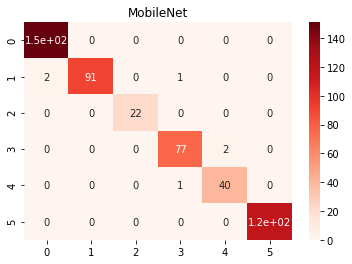

In [32]:
import seaborn as sns
cm=confusion_matrix(valid_generator.classes, y_valid_pred)
sns.heatmap(cm,annot=True,cmap="Reds")
plt.title("MobileNet")
plt.show()

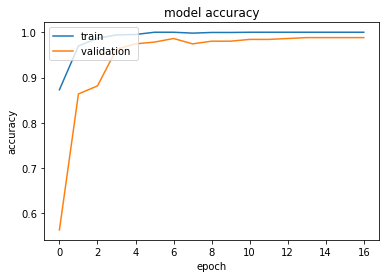

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(["train","validation "], loc='upper left') 
plt.show()